<a href="https://colab.research.google.com/github/dtim-upc/THOR/blob/main/THOR_Conceptualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
isColab = True
try:
  # running on CoLAB Hosted runtime
  print(os.environ['HOSTNAME'])
  print('Running on CoLAB Hosted runtime.')
except:
  # running on Local runtime
  print('You are running this script on your local machine!')
  isColab = False

You are running this script on your local machine!


In [ ]:
'''Installing/Upgrading the Libraries Not Available to CoLAB'''
if isColab:
  !pip install -U 'spacy'==3.5.0
  !pip install -U spacy[cuda-autodetect]
  !pip install -U rdflib
  !pip install -U spaczz
  !pip install coreferee
  !pip install nervaluate
  !pip install -U print-dict

In [ ]:
'''Downloading Model lg = larger - with word vectors'''
if isColab:
  !python -m spacy download en_core_web_lg
  !python -m spacy download en_core_web_trf
  !python -m coreferee install en

  # Adding Word Vectors: https://spacy.io/usage/linguistic-features#adding-vectors
  #!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M-subword.vec.zip
  #!python -m spacy init vectors en wiki-news-300d-1M-subword.vec.zip /content/wiki-news-300d-1M-subword

In [ ]:
import re
import os
import spacy
from spacy.lang.en import English
from spacy.tokenizer import Tokenizer
from spacy.pipeline import Sentencizer
from nervaluate import Evaluator
import coreferee
import bs4
from print_dict import pd as pdic
import requests
from spacy import displacy
from spacy.matcher import Matcher
from spacy.tokens import Span
import matplotlib.pyplot as plt
from tqdm import tqdm
import csv
from textwrap import wrap
import os.path
import functools
import operator
from collections import deque
from operator import itemgetter
from spacy.symbols import nsubj, VERB, AUX

# spaczz lirrary for Similarity Matching
from spaczz.matcher import SimilarityMatcher

# RDFLib libraries
from rdflib import Graph
import pprint
from rdflib import RDFS
from rdflib import URIRef
from rdflib.namespace import RDF

# Colab specific libraries
if isColab:
  from google.colab import files

# General Libraries
import pandas as pd
import srsly
import json
import os
import re
import time
import warnings

import subprocess
import sys

# Spacy Related Imports
import spacy
from spacy.util import minibatch, compounding, compile_infix_regex, get_words_and_spaces
from spacy.tokens import Span, DocBin, Doc
from spacy.vocab import Vocab
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
from spacy.scorer import Scorer
from spacy.training import Example
# import spacy_sentence_bert

# Ignore OOV warnings
warnings.filterwarnings("ignore", message=r"\[W008\]", category=UserWarning)

In [ ]:
# Defining some of the Directories... Please also check the Main function at the bottom
SCHEMA_FILE = "data/schema/Disease_KG_Extended.ttl"
STRUCTURED_DATA_DIR = "data/csv"

#Data Conversion Part

In [ ]:
def trim_entity_spans(text, spans):
  '''Data Cleaning: Removes leading and trailing white spaces from entity spans.'''
  invalid_span_tokens = re.compile(r'\s')

  valid_spans = []
  for start, end, label in spans:
    valid_start = start
    valid_end = end
    while valid_start < len(text) and invalid_span_tokens.match(text[valid_start]):
      valid_start += 1
    while valid_end > 1 and invalid_span_tokens.match(text[valid_end - 1]):
      valid_end -= 1

    if valid_start < valid_end:
      valid_spans.append((valid_start, valid_end, label))

  return valid_spans

In [ ]:
def docanno_to_spacy_ner_db(DATA_DIR):
  '''
  This function takes a directory of docanno annotated datasets for NER/RE
  and converts them into SpaCy DocBin Object which is Trainable via commandline
  '''
  # Creates a blank Tokenizer with just the English vocab
  nlp = spacy.blank("en")

  Doc.set_extension("rel", default={},force=True)
  vocab = Vocab()

  word_count = 0
  no_files = 0
  no_doc = 0
  no_entities = 0
  error_cnt = 0

  # the DocBin will store the example documents
  db = DocBin()

  for dirname, _, filenames in os.walk(DATA_DIR):
    for filename in filenames:
      file_path = os.path.join(dirname, filename)

      try:
        """ Iterate through the Jsonl file to create serialize Docbin object / .spacy IOB File """
        for json_line in srsly.read_jsonl(file_path):

          # parsing the docanno JSON data (per-line)
          text = json_line["text"]
          spans = json_line["entities"]

          new_spans = []
          for span in spans:
            new_spans.append((span["start_offset"], span["end_offset"], span["label"]))

          # cleaning and validating the leading and trailing spaces from the annotated entities
          valid_spans = trim_entity_spans(text, new_spans)

          """ Parsing tokens from Text """
          tokens = nlp(text)

          entities = []

          spaces = [True if tok.whitespace_ else False for tok in tokens]
          words = [t.text for t in tokens]
          doc = Doc(nlp.vocab, words=words, spaces=spaces)

          for start, end, label in valid_spans:
            """ The modes should be: strict, contract, and expand """
            # print(eg['text'][int(span["start_offset"]):int(span["end_offset"])])
            entity = doc.char_span(start, end, label=label, alignment_mode='contract')

            # Not considering the spans which are Erroneous
            if entity is None:
              error_cnt += 1
              # file_name = ttext.split('\n')[0]
              # print(f'Error Found in File: {file_name};\n Span = {start}-{end}; Phrase = {doc.text[start:end]}; Label = {label}\n')

            else:
              no_entities += 1
              entities.append(entity)

          # print(entities)
          try:
            doc.ents = entities
            word_count += len(words)-int(7)
          except:
            # print("=>> Error")
            continue

          db.add(doc)
          no_doc += 1

      except:
        print('Error While Loading JSON Data From Input Directory. Please check if you have other file type...')

      no_files +=1
  print(f"- Files: {no_files} \n- Processed Documents: {no_doc} \n- Total Entities: {no_entities} \n- Erroneous Entities (Ignored): {error_cnt} \n- Total Words: {word_count}")

  return doc, db

In [ ]:
def load_json_from_docbin(file_path: str, nlp):
  '''This function loads data from SpaCy docbin formatted files into spacy compitable JSON format'''
  doc_bin = DocBin().from_disk(file_path)
  samples, entities_count = [], 0
  for doc in doc_bin.get_docs(nlp.vocab):
    sample = {
      "text": doc.text,
      "entities": []
    }
    if len(doc.ents) > 0:
      # print(doc.ents)
      entities = [(e.start_char, e.end_char, e.label_) for e in doc.ents]
      sample["entities"] = entities
      entities_count += len(entities)
    else:
      warnings.warn("Sample without entities!")
    samples.append(sample)
  return samples, entities_count

#Reading Data

In [ ]:
import en_core_web_trf
# TODO - we can aditionally remove the unnecessary pipeline from it -- **speed improvement**
nlp_trf = en_core_web_trf.load()

In [ ]:
# #Using custom Word Vector Models
# if isColab:
#   nlp = spacy.load("/content/wiki-news-300d-1M-subword")
# else:
#   nlp = spacy.load("Embeddings/glove-840B-300d")

In [ ]:
# '''Import the appropriate model and adding the extra pipeline needed'''
# # import en_core_web_md
import en_core_web_lg

nlp = en_core_web_lg.load()

# # sbd = nlp.create_pipe('sentencizer')
nlp.add_pipe('sentencizer')

In [ ]:
def get_rdf_graph(file_name=""):
  '''Getting the RDF file from the user (.nt/.ttl/.xml etc)'''

  # parsing the graph
  g = Graph()
  g.parse(file_name)

  # # Loop through some of the triples in the graph (subj, pred, obj)
  # print('\nTotal Triples Found = {}\n'.format(len(g)))
  # print('First 10 Triples:')
  # for triple in list(g)[:10]:
  #     # Check if there is at least one triple in the Graph
  #     # if (subj, pred, obj) not in g:
  #     #    raise Exception("It better be!")
  #     print(triple)

  return g

In [ ]:
def get_templates(g):
  '''Given a RDF graph 'g' this function will return a list of (S, P, O) triples having only names'''

  # Getting all the unique S, P, O from the graph using the RDFS.domain and RDFS.range
  preds_subs = list(g.subject_objects(predicate=RDFS.domain))
  preds_objs = list(g.subject_objects(predicate=RDFS.range))

  # Getting all the subclasses with corresponding superclasses
  sup_sub = g.subject_objects(predicate=RDFS.subClassOf)

  # dictionary having a superclasses and it's subclasses {'Treatment':['Medicine', 'Precaution', 'Surgery']}
  sup_sub_dic = {}

  # populating the dictionary from the graph
  for sc in sup_sub:
    subj = sc[0].split('#')[1]
    obj = sc[1].split('#')[1]

    if obj in sup_sub_dic:
      sup_sub_dic[obj].append(subj)
    else:
      sup_sub_dic[obj] = [subj]

  # dictionary having a structure {'P':['S', 'O']}
  dic_triples = {}

  # gets only the name of Predicates and Subjects splitting from the URI's
  for ps in preds_subs:
    pred = ps[0].split('#')[1]
    subj = ps[1].split('#')[1]
    dic_triples[pred] = [subj]
    # # print(subj, pred)

  # matches the Subjects having specific Predicates with Objects
  for po in preds_objs:
    pred = po[0].split('#')[1]
    obj = po[1].split('#')[1]
    dic_triples[pred].append(obj)
    # # print(pred, obj)

  # saves the triples from the dictionary into a list of tuple -> [(S, P, O)]
  triples_name = []
  for pred in dic_triples:
    subj = dic_triples[pred][0]
    obj = dic_triples[pred][1]

    # checking if the subject is a superclass - we ignore the superclass and only consider it's subclasses
    if subj in sup_sub_dic:
      # copy it's predicate to all it's subclasses (sub_cls) along with the range
      for sub_cls in sup_sub_dic[subj]:
        triples_name.append((sub_cls, pred, obj))
    else:
      triples_name.append((subj, pred, obj))
      # print('({}, {}, {})'.format(subj, pred, obj))

  # print("Total Templates = {}\n".format(len(triples_name)))
  # for triple in triples_name:
  #   print(triple)

  return triples_name

In [ ]:
# for local runtime - upload the file (first time) in the file upload option (left)
graph = get_rdf_graph(file_name = SCHEMA_FILE)

templates = get_templates(graph)
# Keeping only those templates/triples that has Object Type Property as it's Object
print(f'Extracted a Tolta of {len(templates)} Relationship Templates Having Only Object Properties from the Knowledge Graph:\n')
templates = [template for template in templates if template[2] != 'string']
pdic(templates)

Extracted a Tolta of 17 Relationship Templates Having Only Object Properties from the Knowledge Graph:

[('Disease', 'affects', 'Anatomy'), ('Disease', 'caused_by', 'Cause'),
 ('Disease', 'has_complication', 'Complication'), ('Disease', 'has_diagnosis', 'Diagnosis'),
 ('Disease', 'has_precaution', 'Precaution'), ('Disease', 'has_risk_factor', 'Riskfactor'),
 ('Disease', 'has_symptom', 'Symptom'), ('Diagnosis', 'diagnosis_on', 'Anatomy'),
 ('Diagnosis', 'needs', 'Surgery'), ('Medicine', 'has_side_effect', 'Complication'),
 ('Precaution', 'has_side_effect', 'Complication'),
 ('Surgery', 'has_side_effect', 'Complication'), ('Complication', 'influence', 'Anatomy'),
 ('Medicine', 'made_with', 'Composition'), ('Medicine', 'prescribed_for', 'Disease'),
 ('Surgery', 'surgery_for', 'Disease'), ('Surgery', 'surgery_on', 'Anatomy')]


In [ ]:
""" This is just to SHOW the Concepts"""
unique_entities = set()

# Extracting unique subjects and objects from the list
for sub, pred, obj in templates:
  # Adding the '_E' at the end of the Entity Labels since our Ground Truth annotation followed this in order to separate Entities from Relation names
  unique_entities.add(sub + '_E')
  unique_entities.add(obj + '_E')

ENTITY_LABELS = list(unique_entities)
print(ENTITY_LABELS)

['Composition_E', 'Cause_E', 'Riskfactor_E', 'Surgery_E', 'Medicine_E', 'Symptom_E', 'Precaution_E', 'Disease_E', 'Complication_E', 'Diagnosis_E', 'Anatomy_E']


In [ ]:
def input_file(file_name=""):
  '''This function uploads a file and retunrs it's filename'''

  # if file_name is empty, that means we are using CoLAB Google Hosted Runtime
  if not file_name:
    input_file = files.upload()
    file_name = list(input_file.keys())[0]

  # removing the new file if already exits
  path = os.path.abspath(file_name.split('.')[0]+' (1).'+file_name.split('.')[1])
  if os.path.exists(path) == True:
    os.remove(path)

  return file_name

In [ ]:
def get_data_from_csv(file_name=""):
  '''
  This function will get a CSV from the user having TWO COL i.e., Disease_Name, Affected_Anatomy and
  returns a Dictionary having a structure: {"Tuberculosis": ['lungs', 'brain', 'kidneys', 'spine'], ...}
  '''
  # if file_name is empty, that means we are using CoLAB Google Hosted Runtime
  if not file_name:
    file_name = input_file()

  structured_data = {}

  with open(file_name, 'r', encoding='utf-8') as file:
      csvreader = csv.reader(file)
      # we can ignore the header
      header = next(csvreader)
      # print('Reading New Structured Data Source: {}'.format(file_name.split('\\')[1]))
      # print('Data Headers: ', header)

      for row in csvreader:
        # # print(row)
        # splits the comma separated values from the 1st column
        first_cols = row[0].split(',')

        # each of the instances of the first col (subject) will have the same value domain
        for instance in first_cols:
          instance = instance.strip()

          # splits the comma separated values from the 2nd column
          value_domain = row[1].split(',')
          # removes the leading and trailing spaces
          value_domain = [x.strip() for x in value_domain]
          # making instance/value-domain dictionary
          structured_data[instance] = value_domain

  # print('Instances/Values:')
  # print(structured_data)
  # print()

  return header, structured_data

In [ ]:
def accumulate_structured_data(STRUCTURED_DATA_DIR=STRUCTURED_DATA_DIR):
  '''This will read the Structured Data From the CSV Files of a Directory and accumulate them'''
  # DATA: gets the structured data from CSV files
  accu_data = {}

  for dirname, _, filenames in os.walk(STRUCTURED_DATA_DIR):
    for filename in filenames:
      file_path = os.path.join(dirname, filename)
      # # print(file_path)
      sd_header, sd_data = get_data_from_csv(file_path)
      accu_data = accumulate_unique_data(prev_data=accu_data, keys_list=sd_header, data_dic=sd_data)

  # print('\nAfter Structured Data Accumulation:')
  # print(accu_data)

  return accu_data

In [ ]:
def get_text(file_name=""):
  '''Getting the TEXT file from the user'''

  # if file_name is empty, that means we are using CoLAB Google Hosted Runtime
  input_txt = ""
  if not file_name:
    text_file = files.upload()
    file_name = list(text_file.keys())[0]
    input_txt = text_file[file_name].decode("utf-8").strip()

    # removing the new file if already exits
    path = os.path.abspath(file_name.split('.')[0]+' (1).'+file_name.split('.')[1])
    if os.path.exists(path) == True:
      os.remove(path)

  # if the file is called from local runtime with filename specified

  with open(file_name, 'r', encoding='utf-8') as text_file:
    input_txt = text_file.read().strip()

  # print("Contents of the Input Text File:")
  # print(input_txt)

  return input_txt

In [ ]:
def sentence_segmentation(input_txt, print_indx = False):
    '''This Function Segments the Text into Sentences and Tokens'''

    doc = nlp(input_txt)

    sentences = []
    # sentences_tokens = []
    for sent in doc.sents:
        # print(sent)
        # here sentences are strings
        sentences.append(sent.text.strip())
        # here a  particular sentence is a list of strings containing the words/tokens
        # sentences_tokens.append([token.text for token in sent])

    # print('\nTotal Sentence Found = ', len(sentences))

    if print_indx is not False:
        print('\nExample Sentence and Tokens:')
        print(sentences[print_indx])
        # print(sentences_tokens[print_indx])

    return doc, sentences

## Conceptualization (NER)

In [ ]:
def accumulate_unique_data(prev_data, keys_list, data_dic):
  ''' This function creates a set (unique lists) of data for each of the Concepts (e.g., Disease, Sysmtoms, Anatomy etc.)
      Parameters:
        pre_data  -> already created dictionary with other data sources previously
        keys_list -> list of keys (column names) for the new data source
        data_dic  -> a dictionary holding the source

      Returns:  a dictionary having the keys_list as key and a list of unique (set) values from the data source
  '''
  new_data = {}
  # if we have data already residing in the prev_dic
  if prev_data:
    new_data = prev_data

  # get a list from the keys of the data_dic - for example list of disease names
  keys_data_list = list(data_dic.keys())

  values_data_list = list(data_dic.values())
  # flattening the list of lists and taking only a the unique values
  values_data_list = list(set(functools.reduce(operator.iconcat, values_data_list)))

  # merging the above tow in a single list of lists
  data_lists = [keys_data_list, values_data_list]

  # Accumulates the new data into Key and Value while merging prev values if the key is already present
  for key, val in zip(keys_list, data_lists):
    if key in new_data:
      pre_val = new_data[key]
      # # print(pre_val)
      val = list(set(functools.reduce(operator.iconcat, [val + pre_val])))
      # # print(val)

    # removing empty string from the instances
    if '' in val:
      val.remove('')

    new_data[key] = val

  # # print(new_data,'\n')
  return new_data

In [ ]:
def initiate_matcher(patterns, threshold=80):
  '''Initializing and Fine-tuning the matcher'''
  # For more information of how it works please see: https://github.com/gandersen101/spaczz
  # changing min_r2 from default of 75 to produce matches in this example -- using custom vocab doesn't work for now
  matcher = SimilarityMatcher(vocab=nlp.vocab, min_r2=threshold)

  # UNCOMMENT - this if you set the threshold level to below 50
  # matcher = SimilarityMatcher(vocab=nlp.vocab, min_r2=threshold, min_r1=1)

  for key_concept in patterns:
    # # print(key_concept)

    pattern = [nlp(instance.lower()) for instance in patterns[key_concept]]
    # pattern = [nlp(patterns[key_concept])]

    # we can add as many patterns as we want with specified names of Keys/Concepts
    matcher.add(key_concept, pattern)

  return matcher

In [ ]:
def strip_noun_chunks(np_chunks, sent):
  ''' Removes leading and trailing stop words from noun chunks '''
  cleaned_chunks = []
  for chunk in np_chunks:
    start = chunk.start
    end = chunk.end

    # Move start and end while they point to a stop word
    while start < end and sent[start].is_stop:
      start += 1
    while start < end and sent[end - 1].is_stop:
      end -= 1

    # If there's any non-stop word left, create a new span with the new start and end
    if start < end:
      cleaned_chunks.append(Span(sent, start, end, label=chunk.label))

  return cleaned_chunks

In [ ]:
def identify_noun_chunks(SENTENCES):
  ''' This function iterates over the sentences and splits them into NP (Noun Chunks)
  '''
  # doc = nlp("Typical symptoms of active Tuberculosis are chronic cough with blood-containing mucus, fever, night sweats, and weight loss.")
  # NP per sentence {indx:(sen_indx, [chunk1, chunk1,...])}
  np_sentences = {}

  for indx, sentence in enumerate(SENTENCES):
    # print("\nSENTENCE-{}: {}\n".format(indx, sentence))
    # This is using Transformer Based Model to generate better Dependency Parsing.
    sent = nlp_trf(sentence)

    # Extracts noun chunks possibly with leading and trailing stop words from the sentence
    np_chunks = [chunk for chunk in sent.noun_chunks]

    # We are cleaning the chunks from leading/trailing/fully-containing stop words
    clean_np_chunks = strip_noun_chunks(np_chunks, sent)

    np_sentences[indx] = (sent, clean_np_chunks)

  return np_sentences

In [ ]:
from difflib import SequenceMatcher

def sequence_similarity(phrase, pattern):
  return SequenceMatcher(None, phrase, pattern).ratio()

def word_overlap(phrase, pattern):
  '''This function computes the no. of overlaps between the lemmatized tokens of two nlp objects '''
  phrase_words_set = {token.lemma_.lower() for token in phrase if not token.is_punct}
  pattern_words_set = {token.lemma_.lower() for token in pattern if not token.is_punct}

  # score = Intersection / Union (similar to IoU score)
  # The & operator gives the intersection of two sets, while | gives set union
  word_overlap_score = (len(phrase_words_set & pattern_words_set)/len(phrase_words_set | pattern_words_set))

  return word_overlap_score

In [ ]:
def remove_dup_match(matches):
  '''This function will remove the matched instances where they have same span and entity type but different confidence score
    Example:
      (abdomen, 35, 36, Anatomy, 1.0)
      (abdomen, 35, 36, Anatomy, 0.5)
      (abdomen, 35, 36, Anatomy, 0.3)
  '''
  filtered_dict = {}

  for match_tup in matches:
    # We'll create a dictionary with keys as a combination of (match_id, start, end) and values as the original tuple.
    match_id, start, end, confidence_score, pattern = match_tup
    key = (match_id, start, end)

    # If we encounter a tuple with the same (match_id, start, end) but a higher confidence_score, we'll update the dictionary value.
    if key not in filtered_dict or confidence_score > filtered_dict[key][3]:
      filtered_dict[key] = match_tup

  return list(filtered_dict.values())

In [ ]:
def matching_and_ranking(np_sentences, matcher, top_k=1):
  ''' Need More Details: This is a Core function that uses Word Vectors internally to match similar concepts...!! '''

  # matches per sentence {i:[(np_chunk, matched_sub_chunk, pattern_concept, confidence), ...]}
  matched_sentences = {}

  for i in np_sentences:

    sent, clean_np_chunks = np_sentences[i]
    matches_sent = []
    # print(f"\nSENTENCE-{i+1}: {sent}")

    for chunk in clean_np_chunks:
      phrase = nlp(chunk.text.lower())

      # TODO: we could apply the Matcher for the whole DOCUMENT - to check **speed improvement**
      matches_orig = matcher(phrase)

      matches = []

      # We go for further ranking (+sorting) using two more matching techniques
      for match_id, start, end, ratio, pattern in matches_orig:

        # Exception: This is a special case of possessive noun which we need to ignore from the matching results
        if(phrase.text =="'s"):
          continue

        # Word overlaps - providing nlp objects for better tokenization
        word_matched = word_overlap(phrase[start:end], nlp(pattern))

        # Gestalt pattern matching - difflib
        seq_sim = sequence_similarity(phrase[start:end].text, pattern)

        # Mean Similarity Score from the 2 matchers - 'ratio' is out of 100 so we normalized it
        # confidence_score = (ratio/100 + word_matched)/2
        confidence_score = (ratio/100 + word_matched + seq_sim)/3
        confidence_score = round(confidence_score, 2)

        matches.append((match_id, start, end, confidence_score, pattern))

      # Removing duplicate matches having same span as well as same entity type (matching id)
      # matches = remove_dup_match(matches)

      # Sorting the list of tuples by 'confidence score'
      matches.sort(key=itemgetter(3), reverse=True)

      # TODO: For now we are only taking the TOP-3 matching results.
      for match_id, match_start, match_end, conf, pattern in matches[0:top_k]:
        # This is to track down the matches within the whole Sentence
        sent_start = chunk.start + match_start
        sent_end = chunk.start + match_end
        matched_sub_chunk = Span(sent, sent_start, sent_end, label=chunk.label)

        # TODO: If we need we can also include the NP (chunk) here for future use
        matches_sent.append((chunk, matched_sub_chunk, match_id, conf))

        # print(f'Chunk = {chunk}, Match Start = {match_start}, Match End = {match_end}, Matched Sub-Chunk = {matched_sub_chunk}, Concept = {match_id}, Confidence = {conf}, Pattern = {pattern}')

    # Adding the (sent, matches) to the dictionary with Sentence Index as Key for return purpose
    matched_sentences[i] = (sent, matches_sent)

  return matched_sentences

In [ ]:
def print_match(matched_sentences):
  # print('Final List of Concepts in this Sentence:\n')

  count = 0
  for S_i in matched_sentences:
    sent, matches = matched_sentences[S_i]

    print("Sentence-{}: '{}'".format(S_i, sent))
    # print(matches)

    for np_chunk, matched_sub_chunk, match_id, conf in matches:
      print(f'\t\tNP Chunk = {np_chunk}, Matched Sub-Chunk = {matched_sub_chunk}, Match Start = {matched_sub_chunk.start}, Match End = {matched_sub_chunk.end}, Concept = {match_id}, Confidence = {conf}')
      count += 1
    print()

  print(f'\nTotal Entities Recognized in Sentences = {count}')

In [ ]:
def conceptualized_preprocessed_doc(prep_doc, matched_sentences):
  ''' This function will map the sentence based matching results into the coreferred documents.
      The chunks produces here uses token based span according to the pre-processed document as a whole.

      Returns a list of 3 tuples (np_chunk_doc, matched_sub_chunk_doc, match_id, conf)
      --> [(Abdominal aortic aneurysm, Abdominal aortic aneurysm, 'Disease', 1.0), (Abdominal aortic aneurysm, Abdominal, 'Anatomy', 0.62), ...]
  '''

  entities_pre_doc = []
  for i, sent in enumerate(prep_doc.sents):
    sent_from_matcher, matched_results = matched_sentences[i]

    for np_chunk, matched_sub_chunk, match_id, conf in matched_results:
      # Adjust the start and end indices of NP Chunk according to the doc
      np_chunk_doc_start = sent.start + np_chunk.start
      np_chunk_doc_end = sent.start + np_chunk.end

      # Adjust the start and end indices of matched sub-chunk according to the doc
      sub_chunk_doc_start = sent.start + matched_sub_chunk.start
      sub_chunk_doc_end = sent.start + matched_sub_chunk.end

      # Making token based span according to the doc
      np_chunk_doc = Span(prep_doc, np_chunk_doc_start, np_chunk_doc_end, label=np_chunk.label)
      matched_sub_chunk_doc = Span(prep_doc, sub_chunk_doc_start, sub_chunk_doc_end, label=matched_sub_chunk.label)
      entities_pre_doc.append((np_chunk_doc, matched_sub_chunk_doc, match_id, conf))

      # print(matched_sub_chunk, matched_sub_chunk_doc)

  # print(f'\nTotal Entities Mapped in Document = {len(entities_pre_doc)}')
  return entities_pre_doc

In [ ]:
def get_char_span(orig_doc, input_txt, entities_pre_doc, tag_np_chunk_only = False):
  '''This function conversts token span into character span for the evaluation script to work.
     You can choose either to tag the NP Chunk or to be more granular by tagging with Sub-Chunk level matching (default).
     The original document object is also populated with the token span so that we can visualize the results of our prediction
  '''

  entities_span = []
  doc_span = []

  if tag_np_chunk_only:
    for np_chunk_doc, matched_sub_chunk_doc, match_id, conf in entities_pre_doc:
      # This will be used for SemEval Evaluation
      entities_span.append((np_chunk_doc.start_char, np_chunk_doc.end_char, match_id+'_E'))
      # This will be used to visualize the Span
      doc_span.append(Span(orig_doc, np_chunk_doc.start, np_chunk_doc.end, match_id+'_E'))
  else:
    for np_chunk_doc, matched_sub_chunk_doc, match_id, conf in entities_pre_doc:
      # This will be used for SemEval Evaluation
      entities_span.append((matched_sub_chunk_doc.start_char, matched_sub_chunk_doc.end_char, match_id+'_E'))
      # This will be used to visualize the Span
      doc_span.append(Span(orig_doc, matched_sub_chunk_doc.start, matched_sub_chunk_doc.end, match_id+'_E'))

  # A dictionary in the format {'text': 'Tuberculosis generally damages the lungs', 'entities': [(0, 12, 'Disease_E'), (35, 40, 'Anatomy_E')]}
  ner_prediction = {'text': input_txt, 'entities': entities_span}
  orig_doc.spans["sc"] = doc_span

  return orig_doc, ner_prediction

In [ ]:
def list_to_spacy_ner_doc(ner_pred):
  '''
  This function takes a list of directory of NER predictions of the form
  {'text': '...', 'entities':[(start, end, tag)]} and converts them into SpaCy Doc Object
  '''
  # Creates a blank Tokenizer with just the English vocab
  nlp = spacy.blank("en")

  Doc.set_extension("rel", default={},force=True)
  vocab = Vocab()

  # try:
  # parsing the docanno JSON data (per-line)
  text = ner_pred["text"]
  spans = ner_pred["entities"]

  """ Parsing tokens from Text """
  tokens = nlp(text)

  entities = []

  spaces = [True if tok.whitespace_ else False for tok in tokens]
  words = [t.text for t in tokens]
  doc = Doc(nlp.vocab, words=words, spaces=spaces)

  for start, end, label in spans:
    """ The modes should be: strict, contract, and expand """
      # print(eg['text'][int(span["start_offset"]):int(span["end_offset"])])
    entity = doc.char_span(start, end, label=label, alignment_mode='contract')

    # Not considering the spans which are Erroneous
    if entity is None:
      # file_name = text.split('\n')[0]
      # print(f'No Entity Found in File: {file_name};\n Span = {start}-{end}; Phrase = {doc.text[start:end]}; Label = {label}\n')
      continue
    else:
      entities.append(entity)

  # print(entities[0].label_)
  try:
    doc.ents = entities
  except:
    print("=>> Error")
    print(text)

  # except:
  #   print('Error While Loading Predicted List...')

  return doc

In [ ]:
'''Assigns different colors to the Entities during visualization.'''

color_list = ['yellow', 'white', 'orange', '#0D9CB4', '#5813C7', '#0D350E', '#1AA436',
          '#1AE0F9', '#BADCA1', '#78A2E5', '#D845FB', '#54B69E']

colors = dict(zip(ENTITY_LABELS, color_list))
options = {"colors": colors}

In [ ]:
def render_pred_span_cat(doc):
  '''Desired Format: doc.spans["sc"] = [Span(doc, 3, 6, "ORG"), Span(doc, 5, 6, "GPE")]
  '''
  spacy.displacy.render(doc, style="span", options=options, jupyter=True)

In [ ]:
def render_groud_truth_entities(doc):
  spacy.displacy.render(doc, style="ent", options=options, jupyter=True)

In [ ]:
def save_predictions(ner_predictions, filename, semeval_format=True):
  # Saving the predictions as JSON - each dictionary on a line
  semeval_ent = []
  with open(OUTPUT_DIR+'/'+filename, 'w', encoding='UTF-8') as json_file:
    for pred in ner_predictions:
      if semeval_format:
        # prodigy format to work with nereval library - for SemEval 2013 - 9.1 task.
        tmp_ent = []
        for ent in pred['entities']:
          # saved in this format: [{"label": "PER", "start": 2, "end": 4}, ... ]
          tmp_ent.append({"label": ent[2], "start": ent[0], "end": ent[1]})

        semeval_ent.append(tmp_ent)

      else:
        # this is regullar spacy format, can be used for spacy's default evaluation later
        json_file.write(json.dumps(pred, ensure_ascii=False))
        json_file.write('\n')

    if semeval_format:
      # dumping it into a JSON file
      json_file.write(json.dumps(semeval_ent, ensure_ascii=False))

  return semeval_ent
  # # This is single line JSON Dump of the entile list of dictionary - parser cannot parse it directly
  # with open(OUTPUT_DIR+'/predition.jsonl', 'w') as fout:
  #     json.dump(ner_predictions, fout)

In [ ]:
def process_results(results_by_tag):
  '''This fucntion is used to process the individual entity based scores together'''
  results_by_entity = []
  for entity in ENTITY_LABELS:
    df = pd.DataFrame(results_by_tag[entity])
    df = df.round(decimals = 2)
    df.insert(0,'Entity','')
    df['Entity'] = entity
    results_by_entity.append(df)

  return results_by_entity

In [ ]:
def semeval_evaluation(true, pred):
    evaluator = Evaluator(true, pred, tags=ENTITY_LABELS)
    results, results_by_tag = evaluator.evaluate()

    results = pd.DataFrame(results)
    results.to_excel(OUTPUT_DIR+'/'+'overall_benchmark.xlsx')

    results_by_entity = pd.concat(process_results(results_by_tag))
    results_by_entity.to_excel(OUTPUT_DIR+'/'+'entity_benchmark.xlsx')

    return results, results_by_entity

# Main Function

In [ ]:
if __name__=='__main__':

  # Prompting for evaluation set - validation/test
  EVAL_SET = ['valid', 'test', 'train', 'full']
  EVAL_SET = EVAL_SET[int(input('Chose Dataset for Evaluation:\n[0] Validation\n[1] Test\n[2] Training\n[3] Full Dataset\nEnter your choice:'))]

  # Input/Output Directories
  INPUT_DIR = f'data/input/{EVAL_SET}'
  OUTPUT_DIR = f'data/output/{EVAL_SET}'

  print('\nPreparing Evaluation Dataset:')
  doc_valid, db_valid = docanno_to_spacy_ner_db(INPUT_DIR)
  db_valid.to_disk(OUTPUT_DIR + f"/disease_A-Z_{EVAL_SET}.spacy")

  # reading and accumulating structured data
  accu_data = accumulate_structured_data()
  # pdic(accu_data)

  # reading the ground truth entities with text file from spacy docbin
  samples, ground_entities_count = load_json_from_docbin(OUTPUT_DIR + f"/disease_A-Z_{EVAL_SET}.spacy", nlp)

  eval_start_time = time.time()

  # initializing and fine-tuning the matcher
  matcher = initiate_matcher(patterns=accu_data, threshold=75)

  ner_predictions = []
  all_docs = []
  count = 0
  total_doc = len(samples)

  print('\nConceptualization Process Started...')
  # each sample represents one document..
  for ground in samples:
    input_txt = ground['text']
    # print(f'\n{input_txt}')

    # Segmenting the document into sentences - for Conceptualization we can also process the whole document
    doc, sentences = sentence_segmentation(input_txt, print_indx=False)

    # Detecting the NP Chunks - also removes leading and trailing stop words in the NP chunks
    np_sentences = identify_noun_chunks(sentences)
    # print(np_sentences)

    # Getting the initial Top-k matrching results
    matched_sentences = matching_and_ranking(np_sentences, matcher=matcher, top_k=1)
    # print_match(matched_sentences)

    # Conceptualization (NER) in the coreferenced text document - token based indices
    entities_pre_doc = conceptualized_preprocessed_doc(doc, matched_sentences)
    # print(f'\nEntities in the Coreference Resolved Document:\n{entities_pre_doc}')

    # Organizing char indexes of those entitties according to the original text, also the origina_doc with span categories for visualization
    doc, ner_pred_tmp = get_char_span(doc, input_txt, entities_pre_doc, tag_np_chunk_only = True)
    # print(f'\nNER Prediction for current document:\n{ner_pred_tmp}')
    ner_predictions.append(ner_pred_tmp)
    all_docs.append(doc)

    count +=1
    # print(f'Document-{count}')
    if count % 10 == 0:
      print(f'{count}/{total_doc} Document Processed...')

  eval_end_time = time.time()
  print(f'\nTotal Evaluation Time = {eval_end_time - eval_start_time} (sec)')

  # Visualizing the NER Predictions against the Ground Truth 'samples'
  print('\n########### Prediction ###########\n')
  render_pred_span_cat(all_docs[0])
  print('\n########### Ground Truth ###########\n')
  render_groud_truth_entities(list_to_spacy_ner_doc(samples[0]))

  # saving the grond and predictions into a JSONL file for later evaluation.
  semeval_ground = save_predictions(samples, filename='ground.jsonl')
  semeval_pred = save_predictions(ner_predictions, filename='predition.jsonl')

  # doing the evaluation following SemEval 2013 metrics
  results, results_by_entity = semeval_evaluation(true=semeval_ground, pred=semeval_pred)

  # Saving this for Experiment 2... Spacy Format
  _ = save_predictions(ner_predictions, filename='predition_THOR_spacy.jsonl', semeval_format=False)

Chose Dataset for Evaluation:
[0] Validation
[1] Test
[2] Training
[3] Full Dataset
Enter your choice:1

Preparing Evaluation Dataset:
- Files: 1 
- Processed Documents: 1 
- Total Entities: 26 
- Erroneous Entities (Ignored): 0 
- Total Words: 162

Conceptualization Process Started...

Total Evaluation Time = 35.244094371795654 (sec)

########### Prediction ###########




########### Ground Truth ###########



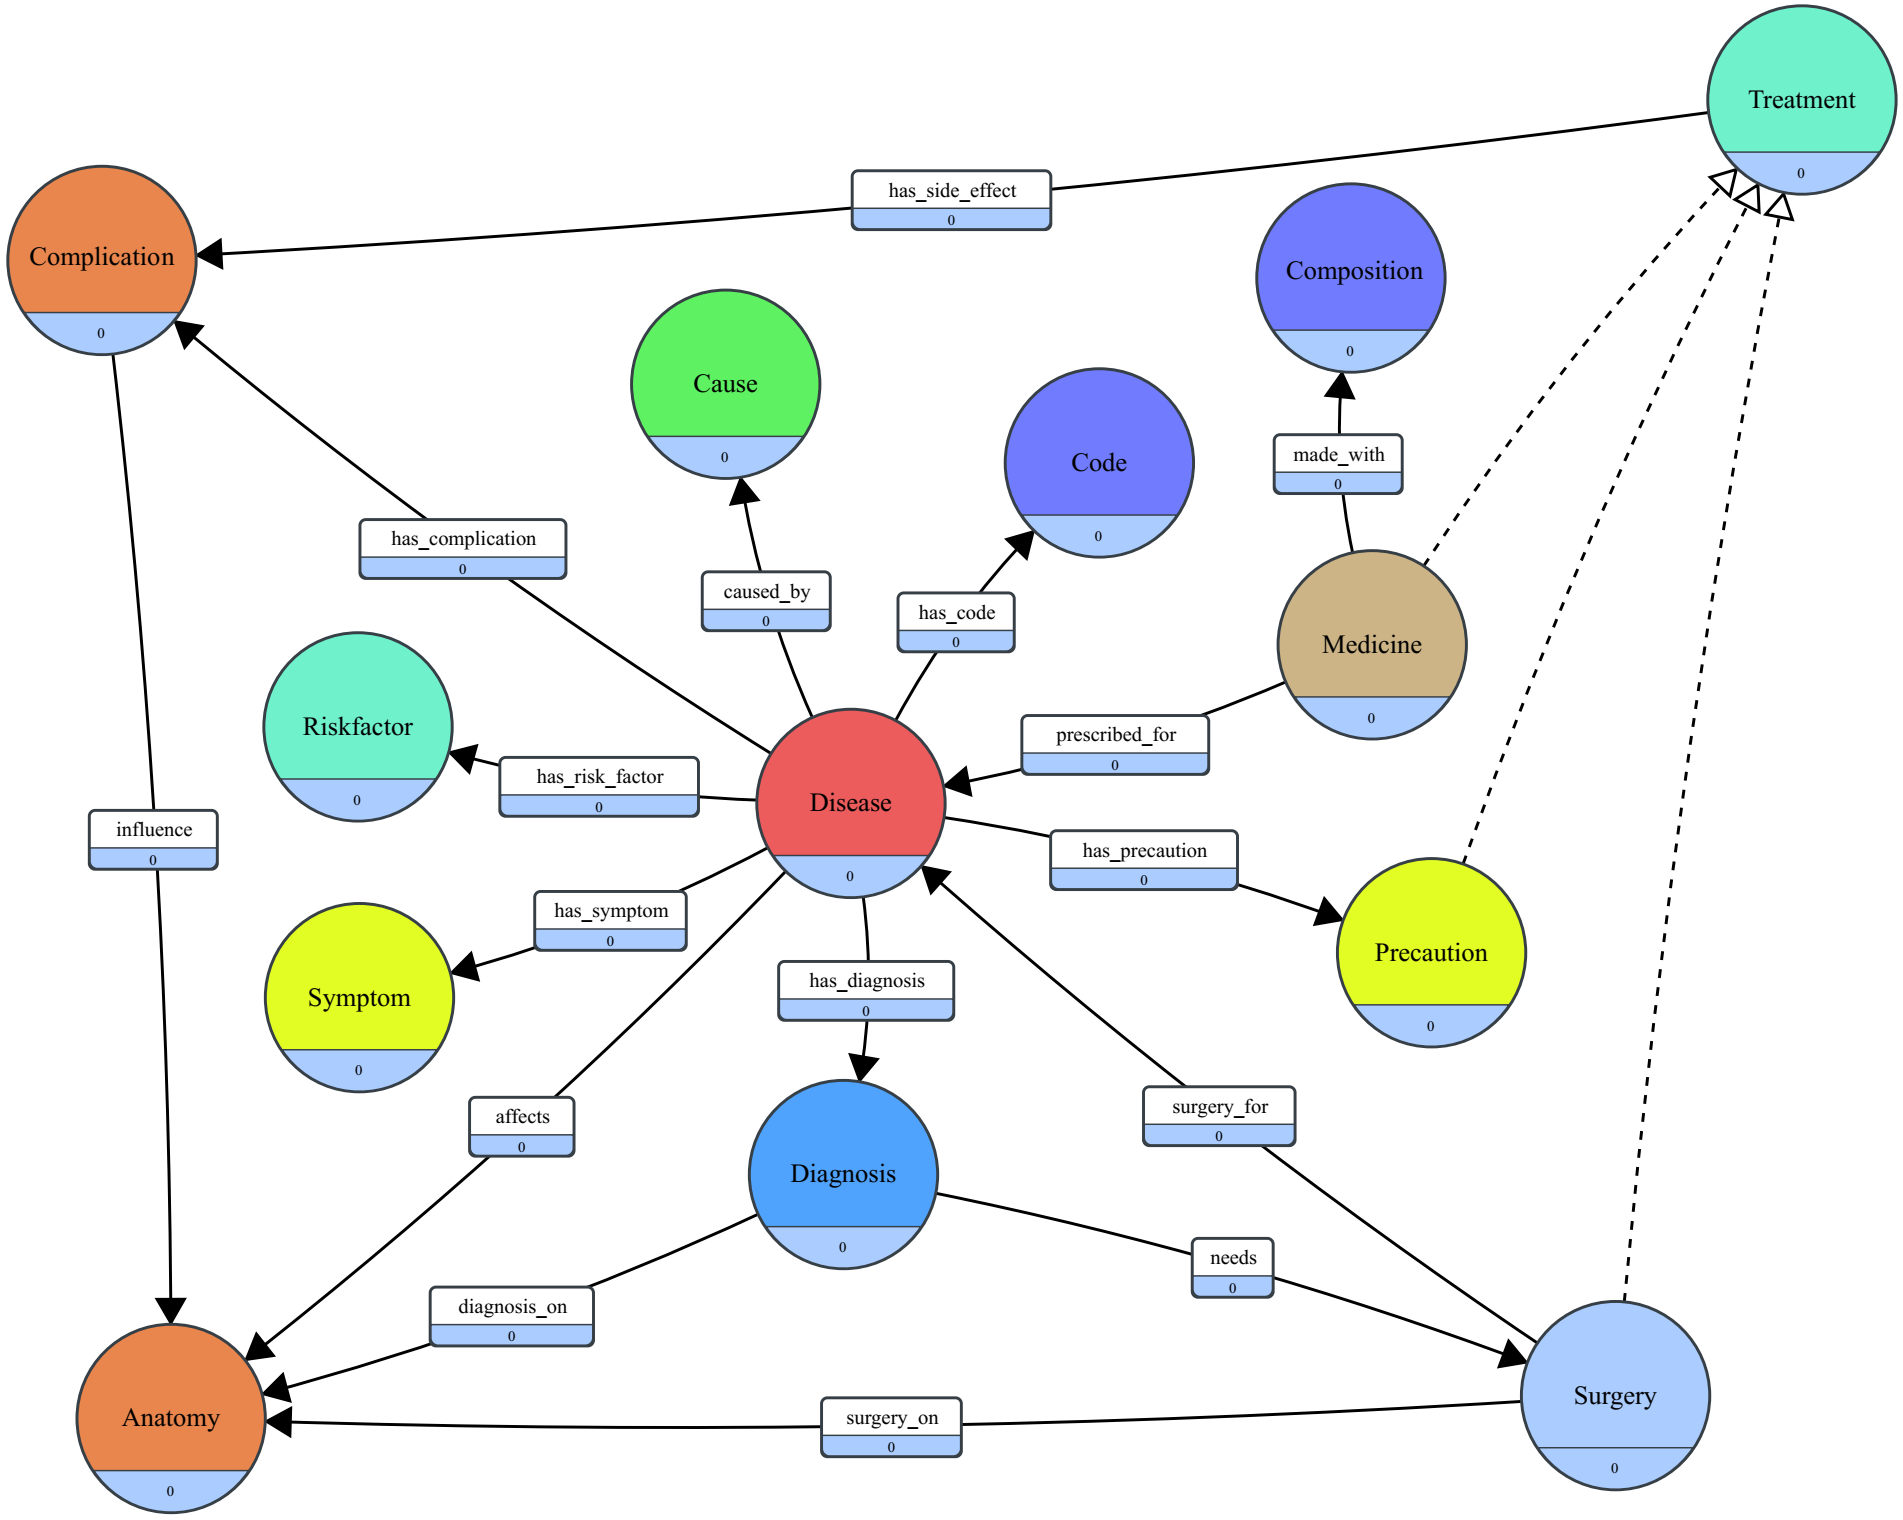

# ISSUES:
1.   Entities (disease) could be either Subject or Object - Solved
2.   Similar for other Entities such as Symptom or Body Part - Solved
3.   Difficulties in the Compound Sentences with comma separated values and connected with 'and', 'such as' etc.
4.   Sub/Obj/Verb with More than 1 word.
5.   Sentence having no ROOT/VERB.
6.   Assignment of triples into wrong templates.
7.   Generic words/phrases - symptoms, infections, disease.
8.   Similarity issues within the Same or Inside a Span having less/more Confidence - **Tricky Cases**
  *   Trying to match only with NP.
  *   Remove elements only within the same NP, keep things from outside the NP.
9. Tracing back the earliers VERB between each pair
10. Comparison between the Similarity/Matched output and Parsed Noun Phrase Chunks should be Tested properly
  * when saving the output, should we only save the Root or the Whole NP
     - AJP are interesting to keep (i.e., fatty liver).
     - Single DET (i.e., the kidney) we can remove the DET.
    * same elements will appear multiple time when only taking the NP (because of not removing them during duplicate removal).
  * we are assuming only the Noun Phrases, their might be match outside NP

11. Uploading the Big Structured Sources causes miss-prediction between similar things because of the embeddings similarity

12. Re-grouping while finding the Lowest Common Ancestors might recursively add childs.

13. While we re-group, we are left with good values even if they are predicted correctly - because of multiple VERBS having only one node.

14. Relations between different LCA. One holding Disease and Another Holding Symptoms.

15. Coreference resolution doesn't always work specially when the span is in another sentence!

16. Remove the same phrase from two different Concepts under the same V-Ancestor. Remove the one that will be in the Object of the Triple.

  *   Example-2:
        * 'Symptom': {Typical signs, night sweats, fever, weight loss, **chronic cough**}
        * 'Disease': {**chronic cough**, active Tuberculosis}




# TO-DO:
1.   Try Wikipedia Vector with Similarity matcher.
2.   Try Sense2Vec (https://explosion.ai/blog/sense2vec-reloaded) ... with wikipedia













